In [2]:
#IMPORTING LIBRARIES
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from scipy import signal
from scipy import stats
# igonre warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  # default='warn'
#read csv as dataframe
df = pd.read_csv('use_case_2/use_case_2/sickness_table.csv')


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1152 non-null   int64  
 1   date        1152 non-null   object 
 2   n_sick      1152 non-null   int64  
 3   calls       1152 non-null   float64
 4   n_duty      1152 non-null   int64  
 5   n_sby       1152 non-null   int64  
 6   sby_need    1152 non-null   float64
 7   dafted      1152 non-null   float64
dtypes: float64(3), int64(4), object(1)
memory usage: 72.1+ KB


In [3]:
# setting the index to datetime, renaming the unnamed column
df["date"]=pd.to_datetime(df.date)
df = df.set_index(['date'])
df.rename( columns={'Unnamed: 0':'Number of Days'}, inplace=True )
df.head()

,Number of Days,n_sick,calls,n_duty,n_sby,sby_need,dafted
date,,,,,,,
2016-04-01,0,73,8154.0,1700,90,4.0,0.0
2016-04-02,1,64,8526.0,1700,90,70.0,0.0
2016-04-03,2,68,8088.0,1700,90,0.0,0.0
2016-04-04,3,71,7044.0,1700,90,0.0,0.0
2016-04-05,4,63,7236.0,1700,90,0.0,0.0


array([[<AxesSubplot:title={'center':'Number of Days'}>,
        <AxesSubplot:title={'center':'n_sick'}>,
        <AxesSubplot:title={'center':'calls'}>],
       [<AxesSubplot:title={'center':'n_duty'}>,
        <AxesSubplot:title={'center':'n_sby'}>,
        <AxesSubplot:title={'center':'sby_need'}>],
       [<AxesSubplot:title={'center':'dafted'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

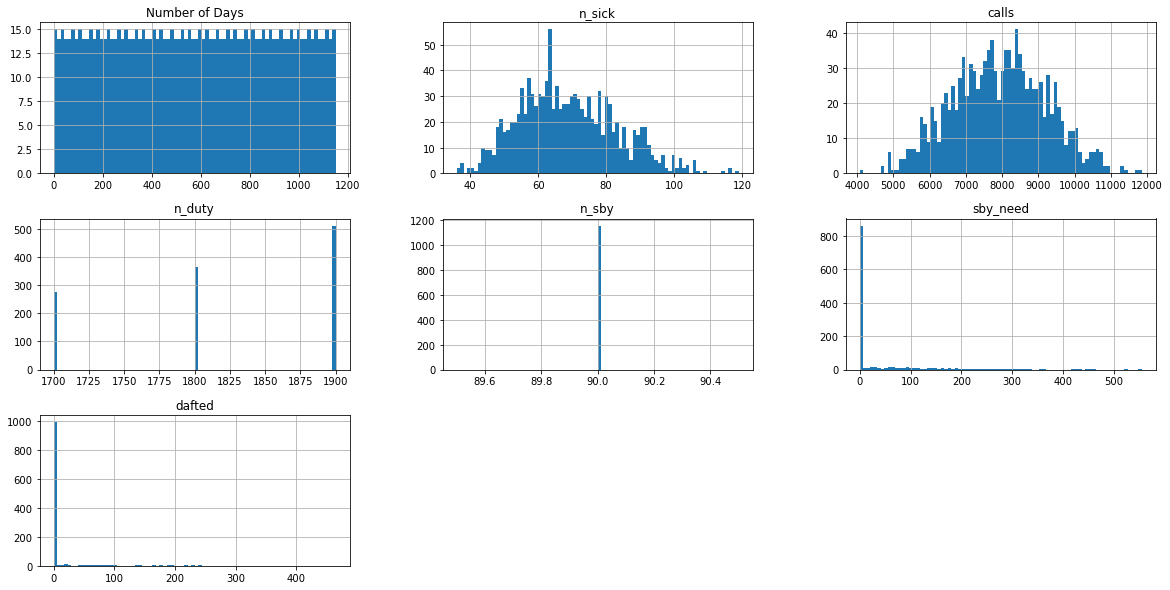

In [4]:
df.hist(bins=80, figsize=(20, 10))

<AxesSubplot:xlabel='date'>

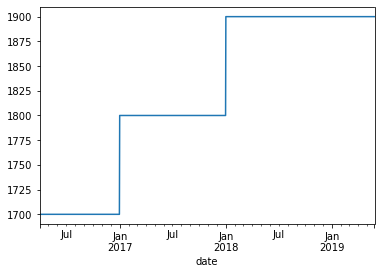

In [5]:
df["n_duty"].plot()

In [6]:
df.loc[df['sby_need'].idxmax()]

Number of Days     1095.0
n_sick               85.0
calls             11850.0
n_duty             1900.0
n_sby                90.0
sby_need            555.0
dafted              465.0
Name: 2019-04-01 00:00:00, dtype: float64

<AxesSubplot:>

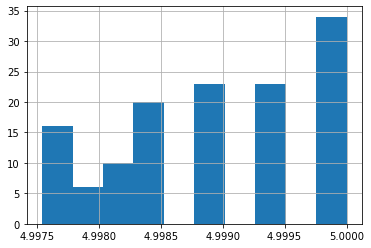

In [7]:
# Defining function to give us the number of total drivers called
def tot_drivers(df):
    df["total_drivers"]=df["n_duty"]+df["sby_need"]-df["n_sick"]
    return df
# Defining function to give us the number of calls per driver
def callsPerDriver(df):
    df["callsPerDriver"]=df["calls"]/df["total_drivers"]
    return df
# testing the number of calls handeled by one driver
df_calls_per_driver_test = df[(df.sby_need != 0)&(df.sby_need <91)].copy()
df_calls_per_driver_test=tot_drivers(df_calls_per_driver_test)
df_calls_per_driver_test=callsPerDriver(df_calls_per_driver_test)
df_calls_per_driver_test.callsPerDriver.hist()

In [8]:
# Functions to extract information from datetime
def date_info1(df):
    df['month'] = df.index.month
    #df['year'] = df.index.year
    df['weekday'] = df.index.weekday
    return df
df=date_info1(df)
df.head()

,Number of Days,n_sick,calls,n_duty,n_sby,sby_need,dafted,month,weekday
date,,,,,,,,,
2016-04-01,0,73,8154.0,1700,90,4.0,0.0,4,4
2016-04-02,1,64,8526.0,1700,90,70.0,0.0,4,5
2016-04-03,2,68,8088.0,1700,90,0.0,0.0,4,6
2016-04-04,3,71,7044.0,1700,90,0.0,0.0,4,0
2016-04-05,4,63,7236.0,1700,90,0.0,0.0,4,1


<AxesSubplot:xlabel='date'>

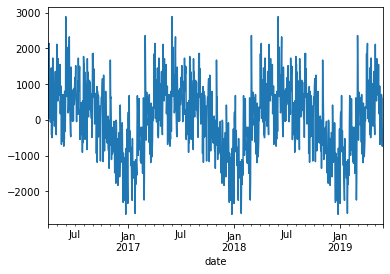

In [9]:
# Unsing seasonal decompose to find seasonal pattenrs and trend
from statsmodels.tsa.seasonal import seasonal_decompose
result_calls = seasonal_decompose(df.calls,period=365)
result_calls.seasonal.plot()


<AxesSubplot:xlabel='date'>

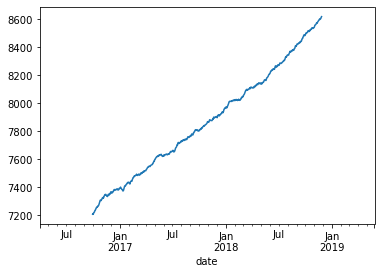

In [10]:
result_calls.trend.plot()

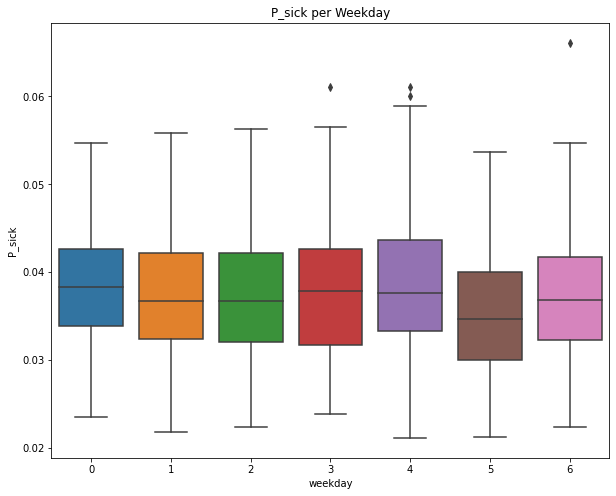

In [11]:
# adding precentage of drivers that are sick
df["P_sick"]=df["n_sick"]/df["n_duty"]
fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="weekday",y="P_sick")
ax.set_title("P_sick per Weekday")
plt.show()

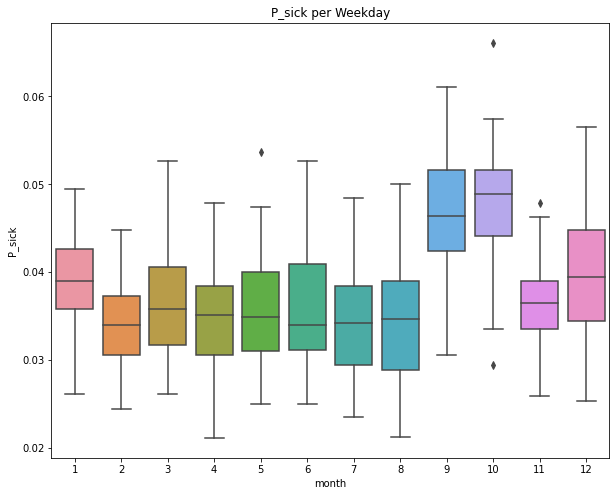

In [12]:
fig, ax= plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x="month",y="P_sick")
ax.set_title("P_sick per Weekday")
plt.show()

In [13]:
from scipy import signal
from scipy import stats
# Finding the trend and adding detrended calls to df
df["detrend_calls"]=signal.detrend(df.calls)
delta = (df.index - df.index[0])
days = delta.days
calls_trend=stats.linregress(days,df.calls)
calls_trend


LinregressResult(slope=1.4955005376372443, intercept=7058.870690589766, rvalue=0.3856787687590593, pvalue=3.6858711922524634e-42, stderr=0.10549720777486982, intercept_stderr=70.1213019020112)

<AxesSubplot:xlabel='date'>

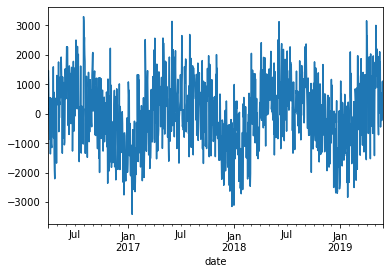

In [14]:
df["detrend_calls"].plot()

In [15]:
def retrend(df):
    df["predicted_calls"]=0
    df["predicted_calls"]=df["Predicted_calls_detrend"]+calls_trend.intercept + calls_trend.slope*df["Number of Days"]
    return df

In [16]:
pd.pivot_table(df ,columns=["weekday"], values=["P_sick","detrend_calls"])

weekday,0,1,2,3,4,5,6
P_sick,0.039004,0.037363,0.037678,0.038079,0.038833,0.035411,0.037595
detrend_calls,306.807317,294.537421,195.834604,64.204957,-32.560726,-202.056227,-623.406273


In [17]:
pd.pivot_table(df ,columns=["month"], values=["P_sick","detrend_calls"])

month,1,2,3,4,5,6,7,8,9,10,11,12
P_sick,0.038793,0.034264,0.036418,0.034867,0.035628,0.035658,0.034270,0.034232,0.046692,0.047272,0.036304,0.039383
detrend_calls,-1022.810640,-569.040809,99.987087,367.058007,606.861101,705.961323,478.167911,597.226749,310.241940,-145.418138,-592.716926,-1159.675929


Metrices

In [18]:
current_model=df.copy()

In [19]:
#Defining evaluation metrics
def evaluation(df):
    copy=df.copy()
    active=0
    total=copy.predicted_sby_needed.sum()
    for i in range(0,len(df)):
        active=active+min(df["predicted_sby_needed"][i],df["sby_need"][i])
    lack_sby_rate=copy.sby_need[copy.sby_need>df.predicted_sby_needed].count()/len(df)
    activation_rate=active/total
    mae=mean_absolute_error(copy["sby_need"],copy["predicted_sby_needed"])
    print("Covrage rate: ",1-lack_sby_rate)
    print("avrage activation rate is ", activation_rate)
    print("Mean absolute error ",mae)
    print("Sby avrage shifts per day ",copy["predicted_sby_needed"].mean())
    print("Answered calls by sby drivers per day ",activation_rate*copy["predicted_sby_needed"].mean()*5)

In [20]:
#evaluation of the current model
current_model["predicted_sby_needed"]=current_model["n_sby"]
evaluation(current_model)

Covrage rate:  0.8515625
avrage activation rate is  0.20425347222222223
Mean absolute error  87.953125
Sby avrage shifts per day  90.0
Answered calls by sby drivers per day  91.9140625


In [21]:
#evaluation of the current model from april 15th
evaluation(current_model.loc[current_model.index>="04-15-2019"])

Covrage rate:  0.5116279069767442
avrage activation rate is  0.5891472868217055
Mean absolute error  119.76744186046511
Sby avrage shifts per day  90.0
Answered calls by sby drivers per day  265.1162790697675


Baseline model

In [22]:
df_baseline=df.copy()

In [23]:
P_sick_pivot=pd.pivot_table(df_baseline.loc[df_baseline.index<"04-01-2019"] ,columns=["month","weekday"], values=["P_sick"]).reset_index()
detrend_calls_pivot=pd.pivot_table(df_baseline.loc[df_baseline.index<"04-01-2019"] ,columns=["month","weekday"], values=["detrend_calls"]).reset_index()

In [24]:
#Setting predicted calls and P_sick to values from the pivot table
def base_line_predict(df):
    df["Predicted_P_sick"]=0
    df["Predicted_calls_detrend"]=0
    for i in range(0,len(df)):
        df["Predicted_P_sick"][i]=P_sick_pivot[df["month"][i]][df["weekday"][i]][0]
        df["Predicted_calls_detrend"][i]=detrend_calls_pivot[df["month"][i]][df["weekday"][i]][0]
    return df
#retrending the calls
def re_trend(df):
    df["predicted_calls"]=0
    df["predicted_calls"]=df["Predicted_calls_detrend"]+calls_trend.intercept + calls_trend.slope*df["Number of Days"]
    return df
# calculating predicted sby needed
def predict_sby(df):
    df['predicted_sby_needed']=0
    df['predicted_sby_needed']=df["predicted_calls"]/5 - df["n_duty"]*(1-df["Predicted_P_sick"])
    return df
# running all the functions from above
def baseline(df):
    df=base_line_predict(df)
    df=re_trend(df)
    df=predict_sby(df)
    return df

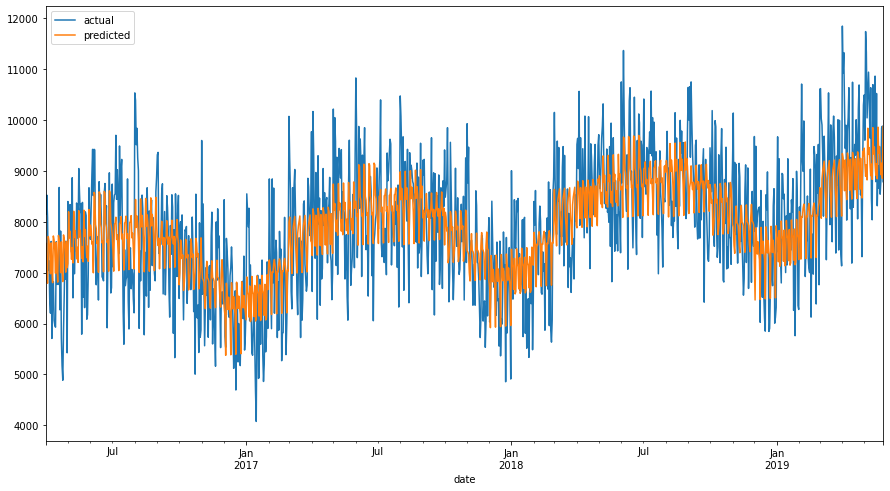

In [25]:
df_baseline=baseline(df_baseline)
fig, ax = plt.subplots(figsize=(15,8))
df_baseline.calls.plot(ax=ax, label="actual")
df_baseline.predicted_calls.plot(ax=ax, label="predicted")
plt.legend(loc="upper left")
plt.show()

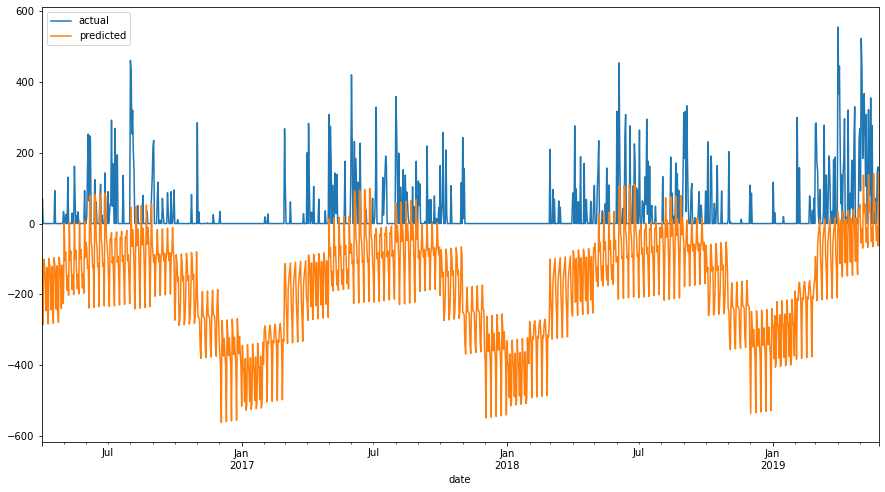

In [26]:
fig, ax = plt.subplots(figsize=(15,8))
df_baseline.sby_need.plot(ax=ax, label="actual")
df_baseline.predicted_sby_needed.plot(ax=ax, label="predicted")
plt.legend(loc="upper left")
plt.show()

In [27]:
# functions that let us set the avrage number of shifhts
def addition_mean(df,n):
    df2=df.copy()
    df2["predicted_sby_needed"]=df2["predicted_sby_needed"]-df2["predicted_sby_needed"].mean()+n
    df2["predicted_sby_needed"]=df2["predicted_sby_needed"].where(df2["predicted_sby_needed"]>0,0)
    return df2
def adjust(df,target):
    n=target
    df2=df.copy()
    df2=addition_mean(df,n)
    while df2["predicted_sby_needed"].mean() > target+1:
        n=n-1
        df2=addition_mean(df,n)
    return(df2)

In [28]:
# setting avrage number o shifts to 90
df_baseline=adjust(df_baseline,90)

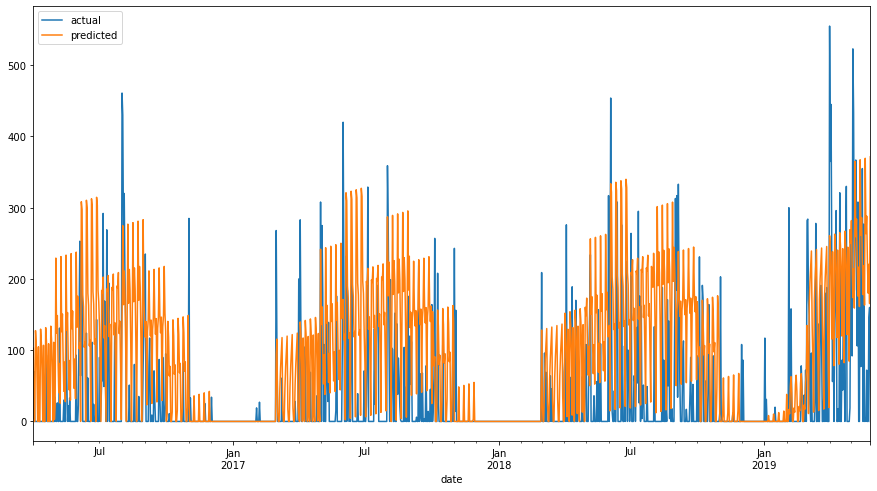

In [29]:
fig, ax = plt.subplots(figsize=(15,8))
df_baseline.sby_need.plot(ax=ax, label="actual")
df_baseline.predicted_sby_needed.plot(ax=ax, label="predicted")
plt.legend(loc="upper left")
plt.show()

In [30]:
evaluation(df_baseline)

Covrage rate:  0.8993055555555556
avrage activation rate is  0.2795285257758278
Mean absolute error  74.65111827990985
Sby avrage shifts per day  90.56130372518675
Answered calls by sby drivers per day  126.57233861319219


In [31]:
evaluation(df_baseline.loc[df_baseline.index>="04-15-2019"])

Covrage rate:  0.7441860465116279
avrage activation rate is  0.47517531865452894
Mean absolute error  146.94714321530492
Sby avrage shifts per day  224.23630684314838
Answered calls by sby drivers per day  532.7577927905388


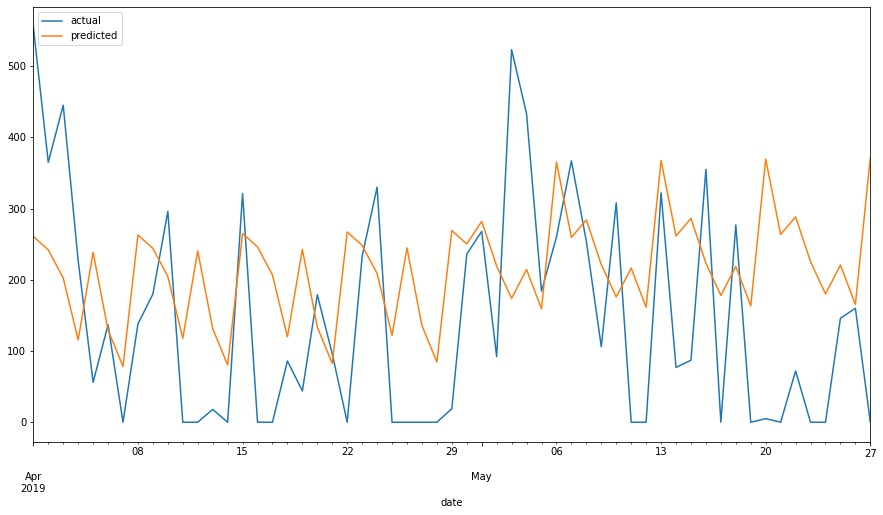

In [32]:
fig, ax = plt.subplots(figsize=(15,8))
df_baseline.loc[df_baseline.index>="04-01-2019"].sby_need.plot(ax=ax, label="actual")
df_baseline.loc[df_baseline.index>="04-01-2019"].predicted_sby_needed.plot(ax=ax, label="predicted")
plt.legend(loc="upper left")
plt.show()

Model building

In [33]:
#Pre procesing function

# defining start date for retrending
day_zero=pd.to_datetime("2016-04-01")
# extrating date features
def date_features(df):
    df["date"]=pd.to_datetime(df.date)
    df = df.set_index(['date'])
    df=df.drop(columns= "Unnamed: 0")
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekday'] = df.index.weekday
    df['Number of Days']=(df.index - day_zero).days
    return df
# detrending calls
def detrend(df):
    df["detrend_calls"]=signal.detrend(df.calls)
    return df
# detrending calls
def P_sick(df):
    df["P_sick"]=df["n_sick"]/df["n_duty"]
    return df
#calling all the functions above
def pre_procesing(df):
    df=date_features(df)
    df=detrend(df)
    df=P_sick(df)
    return df

In [34]:
# functions to change ML results to dataframe
def val_result(validation,y_hat):
    results=pd.DataFrame(validation)
    results["predicted"]=y_hat
    return results

In [35]:
df_model=pd.read_csv('use_case_2/use_case_2/sickness_table.csv')
df_model=pre_procesing(df_model)

# adding peak column, columns of special intrest for our model
df_model["peak"]=np.where((df_model['calls']/5) > (df_model['n_duty']*(1-0.1)), 1, 0)
df_model["peak"]=df_model["peak"]+np.where(df_model['sby_need']>200, 1, 0)
# prepearing data for calls prediction
df_calls=df_model[["day","month","weekday","detrend_calls","peak"]]
# train validation split
df_train_calls=df_calls.loc[df_calls.index<"15-04-2019"]
#replicting peak columns in traning data
df_train_calls=df_train_calls.append([df_train_calls[df_train_calls['peak'] == 1]] * 5, ignore_index=True)
df_train_calls=df_train_calls.append([df_train_calls[df_train_calls['peak']==2]] * 15, ignore_index=True)

df_val_calls=df_calls.loc[df_calls.index>="15-04-2019"]
X_train_calls=df_train_calls.drop(columns=["detrend_calls","peak"])
Y_train_calls=df_train_calls["detrend_calls"]
X_val_calls=df_val_calls.drop(columns=["detrend_calls","peak"])
Y_val_calls=df_val_calls["detrend_calls"]

<ipython-input-35-ae26ff982da8>:10: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_train_calls=df_calls.loc[df_calls.index<"15-04-2019"]
<ipython-input-35-ae26ff982da8>:15: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_val_calls=df_calls.loc[df_calls.index>="15-04-2019"]


In [36]:
# prepearing data for P_sick prediction
df_sick=df_model[["month","weekday","P_sick",]]
df_train_sick=df_sick.loc[df_sick.index<"15-04-2019"]
df_val_sick=df_sick.loc[df_sick.index>="15-04-2019"]
X_train_sick=df_train_sick.drop(columns=["P_sick"])
Y_train_sick=df_train_sick["P_sick"]
X_val_sick=df_val_sick.drop(columns=["P_sick"])
Y_val_sick=df_val_sick["P_sick"]

<ipython-input-36-6c3137cd762d>:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_train_sick=df_sick.loc[df_sick.index<"15-04-2019"]
<ipython-input-36-6c3137cd762d>:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_val_sick=df_sick.loc[df_sick.index>="15-04-2019"]


In [37]:
# traning the calls regressor
from xgboost import XGBRegressor
reg_calls=XGBRegressor(n_estimators=55,learning_rate=0.12, gamma=0, max_depth=2)
reg_calls.fit(X_train_calls, Y_train_calls, eval_set=[(X_train_calls, Y_train_calls), (X_val_calls, Y_val_calls)],verbose=10,early_stopping_rounds=10)

[0]	validation_0-rmse:1345.83972	validation_1-rmse:1206.47681
[10]	validation_0-rmse:913.66840	validation_1-rmse:907.08264
[20]	validation_0-rmse:810.14819	validation_1-rmse:860.36700
[30]	validation_0-rmse:773.38831	validation_1-rmse:851.99658
[40]	validation_0-rmse:754.47156	validation_1-rmse:848.72846
[50]	validation_0-rmse:744.39020	validation_1-rmse:844.88648
[54]	validation_0-rmse:741.50928	validation_1-rmse:844.10687


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.12, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=55, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
# traning the sick regressor
reg_sick=XGBRegressor(n_estimators=120,learning_rate=0.14, gamma=0.0001, max_depth=2)
reg_sick.fit(X_train_sick, Y_train_sick, eval_set=[(X_train_sick, Y_train_sick), (X_val_sick, Y_val_sick)],verbose=10,early_stopping_rounds=10)

[0]	validation_0-rmse:0.39780	validation_1-rmse:0.39440
[10]	validation_0-rmse:0.08845	validation_1-rmse:0.08453
[20]	validation_0-rmse:0.02048	validation_1-rmse:0.01449
[30]	validation_0-rmse:0.00728	validation_1-rmse:0.00336
[38]	validation_0-rmse:0.00592	validation_1-rmse:0.00562


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.0001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.14, max_delta_step=0, max_depth=2,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=120, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [39]:
# this function takes in a date range and returns predictions of number of calls and P_sick for that range
def run_predictions(start_date,end_date):
    x=pd.date_range(start=start_date,end=end_date)
    df=pd.DataFrame(index=x)
    df['day'] = df.index.day
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    calls=df.copy()
    sick=calls.drop(columns="day")
    y_hat_calls=reg_calls.predict(calls)
    df['Predicted_calls_detrend'] =y_hat_calls
    y_hat_sick=reg_sick.predict(sick)
    df['Predicted_P_sick']=y_hat_sick
    df['Number of Days']=(df.index - day_zero).days
    df=retrend(df)
    return df

In [40]:
df_model.head()

,n_sick,calls,n_duty,n_sby,sby_need,dafted,day,month,year,weekday,Number of Days,detrend_calls,P_sick,peak
date,,,,,,,,,,,,,,
2016-04-01,73,8154.0,1700,90,4.0,0.0,1,4,2016,4,0,1095.129309,0.042941,1
2016-04-02,64,8526.0,1700,90,70.0,0.0,2,4,2016,5,1,1465.633809,0.037647,1
2016-04-03,68,8088.0,1700,90,0.0,0.0,3,4,2016,6,2,1026.138308,0.040000,1
2016-04-04,71,7044.0,1700,90,0.0,0.0,4,4,2016,0,3,-19.357192,0.041765,0
2016-04-05,63,7236.0,1700,90,0.0,0.0,5,4,2016,1,4,171.147307,0.037059,0


In [41]:
df_validation=pd.read_csv('use_case_2/use_case_2/sickness_table.csv')
df_validation["date"]=pd.to_datetime(df_validation.date)
df_validation = df_validation.set_index(['date'])
df_validation=df_validation.drop(columns=['Unnamed: 0'])

In [42]:
# creating a validation dataframe with real and predicted values
df_validation=pd.read_csv('use_case_2/use_case_2/sickness_table.csv')
df_validation=pre_procesing(df_validation)
predictions=run_predictions("04-01-2016","05-27-2019")
df_validation["Predicted_P_sick"]=predictions["Predicted_P_sick"]
df_validation["predicted_calls"]=predictions["predicted_calls"]
df_validation2=predict_sby(df_validation)

In [43]:
# creating a max validation dataframe ( 1.0782 -95% 1.13-99.9%)
df_validation_max=df_validation.copy()
df_validation_max["predicted_calls"]=df_validation["predicted_calls"]*1.13
df_validation_max=predict_sby(df_validation_max)

In [44]:
# getting rid of negative sby needed predictions
df_validation["predicted_sby_needed"]=df_validation["predicted_sby_needed"].where(df_validation["predicted_sby_needed"]>0,0)
df_validation_max["predicted_sby_needed"]=df_validation_max["predicted_sby_needed"].where(df_validation_max["predicted_sby_needed"]>0,0)


In [45]:
# function will return a value beween df_validation and df_validation_max based on n (0<=n<=1)
def n_shift(n):
    df_validation_n=df_validation.copy()
    df_validation_n["predicted_sby_needed"]=np.round(df_validation["predicted_sby_needed"]+n*(df_validation_max["predicted_sby_needed"]-df_validation["predicted_sby_needed"]))
    return df_validation_n

In [46]:
def covrage(df):
    copy=df.copy()
    covrage=1-copy.sby_need[copy.sby_need>df.predicted_sby_needed].count()/len(df)
    return covrage

n_vs_lack_rate=[]
i=0
df_validation_n=df_validation.copy()
while i <1:
    df_validation_n=n_shift(i)
    n_vs_lack_rate.append([i,covrage(df_validation_n),df_validation_n["predicted_sby_needed"].mean()])
    i=i+0.01
df_n_act_shifts=pd.DataFrame(n_vs_lack_rate,columns=["n","covrage","n_shifts"])


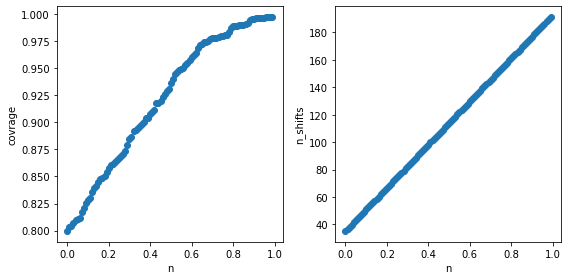

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), tight_layout=True)
plt.subplot(1, 2, 1)
plt.scatter(df_n_act_shifts['n'], df_n_act_shifts['covrage'])
plt.ylabel("covrage")
plt.xlabel("n")
plt.subplot(1, 2, 2) 
plt.scatter(df_n_act_shifts['n'], df_n_act_shifts['n_shifts'])
plt.ylabel("n_shifts")
plt.xlabel("n")
plt.show()

In [48]:
df_n_act_shifts.iloc[(df_n_act_shifts['n_shifts']-90).abs().argsort()[:1]]

,n,covrage,n_shifts
35,0.35,0.896701,90.305556


In [49]:
df_n_act_shifts.iloc[(df_n_act_shifts['covrage']-0.95).abs().argsort()[:1]]

,n,covrage,n_shifts
55,0.55,0.949653,121.828125


In [50]:
print(evaluation(df_validation))
print(evaluation(n_shift(0.35)))
print(evaluation(df_validation_max))


Covrage rate:  0.7986111111111112
avrage activation rate is  0.49366781935879445
Mean absolute error  35.16330802242468
Sby avrage shifts per day  35.10307488164696
Answered calls by sby drivers per day  86.64629214805564
None
Covrage rate:  0.8967013888888888
avrage activation rate is  0.3234389418640418
Mean absolute error  66.60763888888889
Sby avrage shifts per day  90.30555555555556
Answered calls by sby drivers per day  146.04166666666666
None
Covrage rate:  0.9991319444444444
avrage activation rate is  0.18002731601319005
Mean absolute error  158.09624166515977
Sby avrage shifts per day  192.79378809449514
Answered calls by sby drivers per day  173.54074107333838
None


In [51]:
print(evaluation(df_validation[-42:]))
print(evaluation(n_shift(0.35)[-42:]))
print(evaluation(df_validation_max[-42:]))


Covrage rate:  0.5714285714285714
avrage activation rate is  0.6273422954999088
Mean absolute error  103.56325431675776
Sby avrage shifts per day  109.3175974200342
Answered calls by sby drivers per day  342.8977625200958
None
Covrage rate:  0.6666666666666667
avrage activation rate is  0.5154136712562447
Mean absolute error  125.38095238095238
Sby avrage shifts per day  195.4047619047619
Answered calls by sby drivers per day  503.5714285714286
None
Covrage rate:  0.9761904761904762
avrage activation rate is  0.3690184567880224
Mean absolute error  224.48146211651618
Sby avrage shifts per day  355.3046403687619
Answered calls by sby drivers per day  655.5698503925191
None


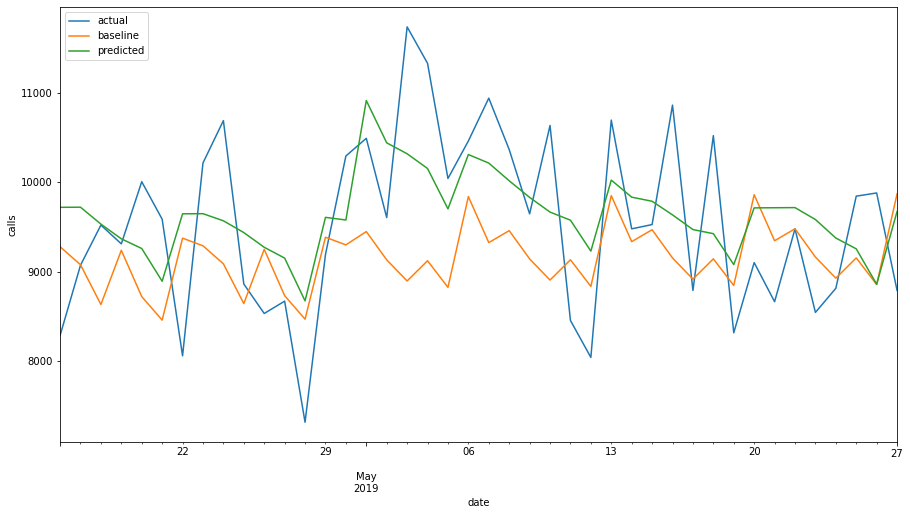

In [52]:
fig, ax = plt.subplots(figsize=(15,8))
df_validation.calls[-42:].plot(ax=ax, label="actual")
df_baseline.predicted_calls[-42:].plot(ax=ax, label="baseline")
n_shift(0.35)[-42:].predicted_calls.plot(ax=ax, label="predicted")
plt.legend(loc="upper left")
plt.ylabel("calls")
plt.show()

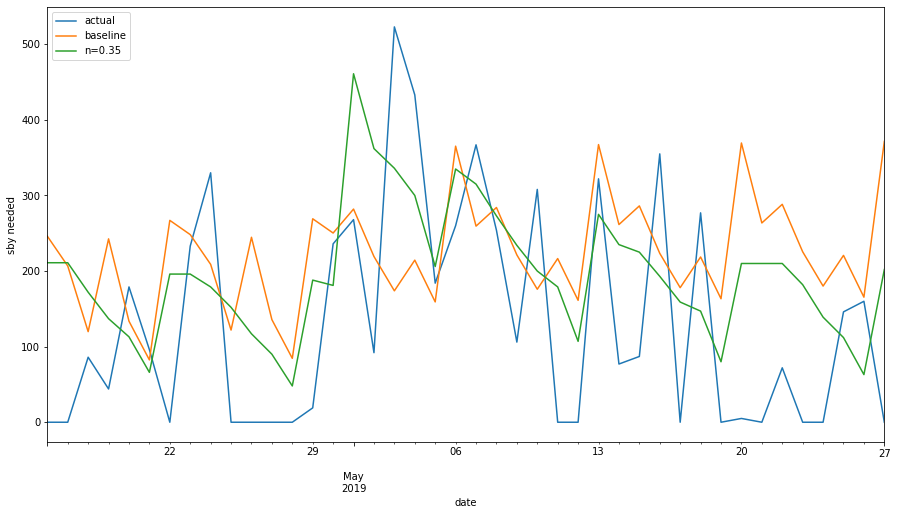

In [53]:
fig, ax = plt.subplots(figsize=(15,8))
df_validation.sby_need[-42:].plot(ax=ax, label="actual")
df_baseline.predicted_sby_needed[-42:].plot(ax=ax, label="baseline")
n_shift(0.35)[-42:].predicted_sby_needed.plot(ax=ax, label="n=0.35")
plt.ylabel("sby needed")
plt.legend(loc="upper left")
plt.show()

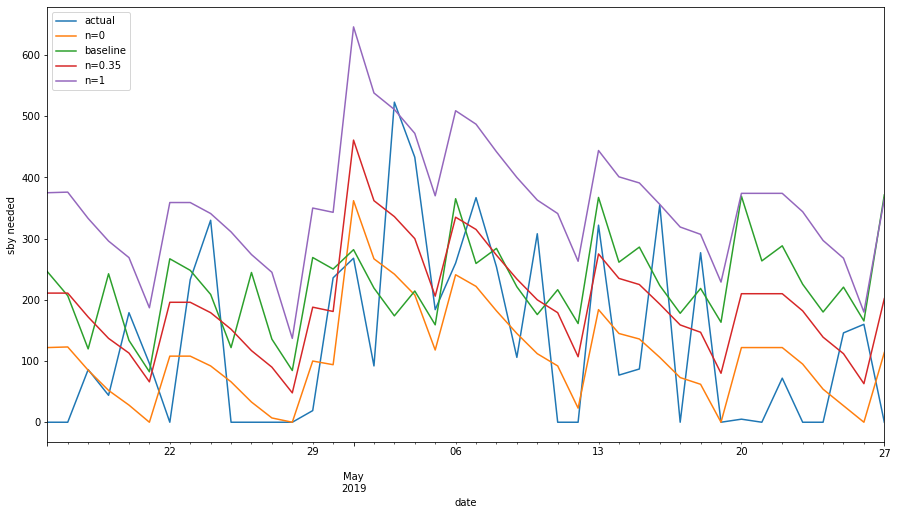

In [54]:
fig, ax = plt.subplots(figsize=(15,8))
df_validation.sby_need[-42:].plot(ax=ax, label="actual")
n_shift(0).predicted_sby_needed[-42:].plot(ax=ax, label="n=0")
df_baseline.predicted_sby_needed[-42:].plot(ax=ax, label="baseline")
n_shift(0.35).predicted_sby_needed[-42:].plot(ax=ax, label="n=0.35")
n_shift(1).predicted_sby_needed[-42:].plot(ax=ax, label="n=1")
plt.ylabel("sby needed")
plt.legend(loc="upper left")

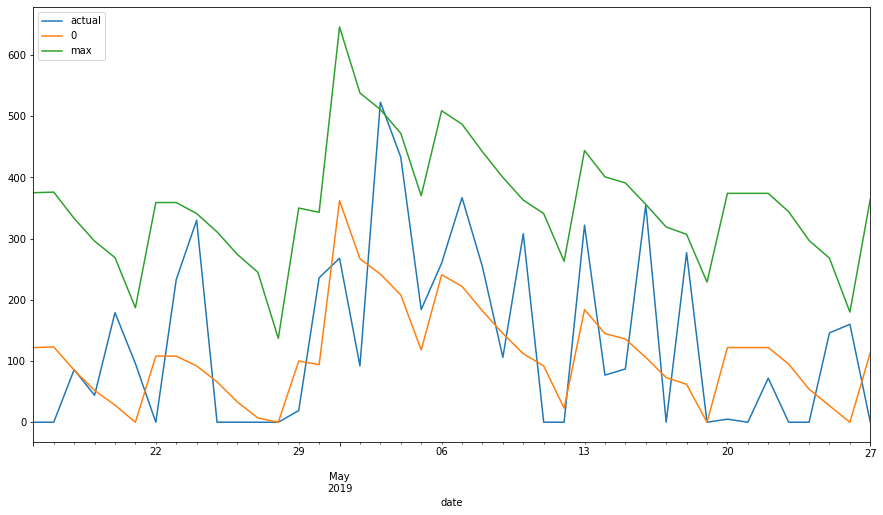

In [55]:
fig, ax = plt.subplots(figsize=(15,8))
df_validation.sby_need[-42:].plot(ax=ax, label="actual")
n_shift(0).predicted_sby_needed[-42:].plot(ax=ax, label="0")
n_shift(1)[-42:].predicted_sby_needed.plot(ax=ax, label="max")
plt.legend(loc="upper left")
plt.show()

final model

In [56]:
def n_shift_final(df,df_max,n):
    df_n=df.copy()
    df_n["predicted_sby_needed"]=np.round(df["predicted_sby_needed"]+n*(df_max["predicted_sby_needed"]-df["predicted_sby_needed"]))
    return df_n

In [57]:
def model(start_date,end_date,n_duty,n):
    df=run_predictions(start_date,end_date)
    df["n_duty"]=n_duty
    df_max=df.copy()
    df_max["predicted_calls"]=df["predicted_calls"]*1.0782
    df=predict_sby(df)
    df_max=predict_sby(df_max)
    df["predicted_sby_needed"]=df["predicted_sby_needed"].where(df["predicted_sby_needed"]>0,0)
    df_max["predicted_sby_needed"]=df_max["predicted_sby_needed"].where(df_max["predicted_sby_needed"]>0,0)
    return (n_shift_final(df,df_max,n))

In [58]:
may=model("05-01-2019","05-31-2019",1900,0.5)

In [59]:
may.predicted_sby_needed.head()

2019-05-01    447.0
2019-05-02    349.0
2019-05-03    323.0
2019-05-04    287.0
2019-05-05    194.0
Freq: D, Name: predicted_sby_needed, dtype: float64

In [60]:
df_2020=model("01-01-2020","01-01-2021",1900,0.35)
df_2021=model("01-01-2021","01-01-2022",1900,0.35)
df_2022=model("01-01-2022","01-01-2023",1900,0.35)
df_2023=model("01-01-2023","01-01-2024",1900,0.35)
print(df_2020.predicted_sby_needed.mean(),df_2021.predicted_sby_needed.mean(),df_2022.predicted_sby_needed.mean(),df_2023.predicted_sby_needed.mean())

print(df_2023.predicted_sby_needed.mean()-df_2022.predicted_sby_needed.mean())
print(df_2022.predicted_sby_needed.mean()-df_2021.predicted_sby_needed.mean())
print(df_2021.predicted_sby_needed.mean()-df_2020.predicted_sby_needed.mean())


231.54223433242507 336.7295081967213 445.8606557377049 557.4508196721312
111.59016393442624
109.13114754098359
105.18727386429626


In [61]:
df_2020=model("01-01-2020","01-01-2021",2090,0.35)
df_2021=model("01-01-2021","01-01-2022",2200,0.35)
df_2022=model("01-01-2022","01-01-2023",2310,0.35)
df_2023=model("01-01-2023","01-01-2024",2420,0.35)
print(df_2020.predicted_sby_needed.mean(),df_2021.predicted_sby_needed.mean(),df_2022.predicted_sby_needed.mean(),df_2023.predicted_sby_needed.mean())

print(df_2023.predicted_sby_needed.mean()-df_2022.predicted_sby_needed.mean())
print(df_2022.predicted_sby_needed.mean()-df_2021.predicted_sby_needed.mean())
print(df_2021.predicted_sby_needed.mean()-df_2020.predicted_sby_needed.mean())

90.25885558583106 95.8743169398907 100.64480874316939 105.92896174863388
5.284153005464489
4.770491803278688
5.615461354059647


Errors

In [70]:
df_errors35=n_shift(0.35)
df_errors35["sby_error"]=df_errors35["predicted_sby_needed"]-df_errors35["sby_need"]
df_errors35["sby_error_abs"]=abs(df_errors35["sby_error"])

In [71]:
df_errors35_norm = df_errors35.drop(df_errors35[df_errors35.sby_need ==0].index)

<AxesSubplot:>

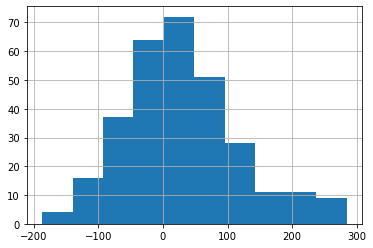

In [72]:
df_errors35_norm.sby_error.hist()

In [103]:
i=0
error_x=[]
error_y=[]
while i<=1:
    error_y.append([df_errors35.sby_error_abs.quantile(i)])
    error_x.append((i)*100)
    i=i+0.01

In [106]:
df_errors35.sby_error_abs.mean()

66.60763888888889

In [107]:
df_errors35.sby_error_abs.median()

54.0

In [125]:
df_errors35.sby_error_abs.quantile(0.25)

16.0

In [128]:
df_errors35.sby_error_abs.quantile(0.75)

95.0

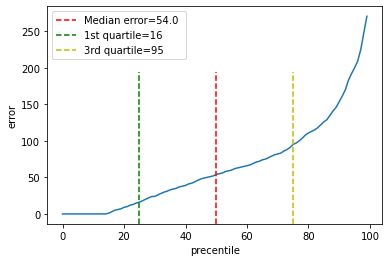

In [137]:
plt.plot(error_x,error_y)
plt.ylabel("asbsolute error")
plt.axvline(x = 50, label = "Median error=54.0 ", ymin=0,ymax=0.5, color="r",ls='--')
plt.axvline(x = 25, label = "1st quartile=16 ", ymin=0,ymax=0.5, color="g",ls='--')
plt.axvline(x = 75, label = "3rd quartile=95 ", ymin=0,ymax=0.5, color="y",ls='--')
plt.ylabel("error")
plt.xlabel("precentile")
plt.legend()